### Реализация KNN языке Python

In [ ]:
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import math

In [ ]:
from enum import Enum
class PredictionType(Enum):
    CLASSIFICATION = 1
    REGRESSION = 2

In [ ]:
class SimpleKNN:

    def fit(self, X_train: np.matrix, y_train: np.ndarray):
        """
        Метод обучения, который фактически не учится,
        а только запоминает обучающую выборку.
        Входные параметры:
        X_train - обучающая выборка (матрица объект-признак)
        y_train - обучающая выборка (вектор целевого признака)
        Возвращаемое значение: нет
        """
        #Сохраняем параметры в переменных класса
        self._X_train = X_train
        self._y_train = y_train

    def eucl_dist(self, p: np.ndarray, q: np.ndarray) -> float:
        """
        Вычисление Евклидова расстояния - https://en.wikipedia.org/wiki/Euclidean_distance
        Входные параметры:
        p, q - вектора в n-мерном пространстве признаков
        """
        return math.sqrt(sum([(pi - qi) ** 2 for pi, qi in zip (p, q)]))


    def predict_for_single_object(self, K: int, \
                prediction_type: PredictionType, \
                X_o: np.ndarray, \
                verbose = True) -> np.ndarray:
        """
        Метод предсказания для одного объекта.
        Входные параметры:
        K - гиперпараметр, количество соседей
        prediction_type - классификация или регрессия
        X_o - строка матрицы объект-признак, соответствующая объекту
        verbose - флаг детального вывода
        Возвращаемое значение: предсказанное значение целевого признака
        """
        # список соседей
        neighbors_list = []
        # *** Находим ближайшие точки ***
        # Перебираем все точки обучающей выборки
        for i in range(self._X_train.shape[0]):
            # получаем текущую точку
            data_train_current_x = [x for x in self._X_train[['x1','x2']].iloc[i]]
            # и значение ее y
            data_train_current_y = self._y_train[i]
            # вычисляем расстояние
            dist = self.eucl_dist(X_o, data_train_current_x)
            # сохраняем в список соседей
            temp_res = (data_train_current_y, dist, data_train_current_x)
            neighbors_list.append(temp_res)
        # *** сортируем список соседей по возрастанию расстояния ***
        # в кортеже элементы следуют в порядке (0,1,2), сортируем по первому элементу
        neighbors_list_sorted = sorted(neighbors_list, key=itemgetter(1))
        if verbose:
            print()
            print('**************************************')
            print('Проверяемая точка: ', X_o)
            print('**************************************')
            print('Вывод отсортированного списка соседей:')
            dist_list = []
            for cur_y, cur_dist, temp_x_1_2 in neighbors_list_sorted:
                temp_x1, temp_x2 = temp_x_1_2
                print('X1={0}, X2={1}, y={2}, расстояние={3:.2f}'.format(temp_x1, temp_x2, cur_y, cur_dist))
                dist_list.append(cur_dist)
            print()
            print('Вывод расстояния для отсортированного списка соседей:')
            plt.plot(dist_list)
            plt.show()
        # Оставим только K ближайших соседей
        K_neighbors_list_sorted = neighbors_list_sorted[:K]
        if verbose:
            print('Вывод К ближайших соседей:')
            x1_list = []
            x2_list = []
            for cur_y, cur_dist, temp_x_1_2 in K_neighbors_list_sorted:
                temp_x1, temp_x2 = temp_x_1_2
                x1_list.append(temp_x1)
                x2_list.append(temp_x2)
                print('X1={0}, X2={1}, y={2}, расстояние={3:.2f}'.format(temp_x1, temp_x2, cur_y, cur_dist))
            print()
            print('Визуализация К ближайших соседей:')
            plt.plot(self._X_train['x1'], self._X_train['x2'], 'b.', \
                     x1_list, x2_list,  'g*', \
                    [X_o[0]], [X_o[1]], 'ro')
            plt.show()
        # Результат - классификация или регрессия
        if prediction_type == PredictionType.REGRESSION:
            # используем numpy для вычисления среднего значения
            arr = np.array([x for x,_,_ in K_neighbors_list_sorted])
            # возвращаем среднее значение
            return np.mean(arr)
        elif prediction_type == PredictionType.CLASSIFICATION:
            k_y_list = [y for y,_,_ in K_neighbors_list_sorted]
            # группируем с количеством метки классов,
            # соответствующие K ближайшим соседям
            k_y_list_grouped_temp = np.unique(k_y_list, return_counts=True)
            k_y_list_grouped = [[key, cnt] for key, cnt in zip(k_y_list_grouped_temp[0], k_y_list_grouped_temp[1])]
            # сортируем по количеству по убыванию
            k_y_list_grouped_sorted = sorted(k_y_list_grouped, key=itemgetter(1), reverse=True)
            if verbose:
                print('Классы, соответствующие К ближайшим соседям:')
                for i in k_y_list_grouped_sorted:
                    print('класс={0}, количество элементов={1}'.format(i[0], i[1]))
            # возвращаеv метку класса из первой строки отсортированного массива
            # то есть того класса, к которому принадлежит наибольшее количество соседей
            return k_y_list_grouped_sorted[0][0]
        else:
            raise Exception('Неизвестный тип предсказания')


    def predict(self, K: int, \
                prediction_type: PredictionType, \
                X_test: np.matrix,
                verbose = True) -> np.ndarray:
        """
        Метод предсказания.
        Входные параметры:
        K - гиперпараметр, количество соседей
        prediction_type - классификация или регрессия
        X_test - тестовая выборка (матрица объект-признак)
        Возвращаемое значение: предсказанный вектор целевого признака
        """
        # Перебираем все точки тестовой выборки
        test_data_temp = []
        for i in range(X_test.shape[0]):
            # получаем текущую точку
            data_test_current_x = [x for x in X_test.iloc[i]]
            test_data_temp.append(data_test_current_x)
        return [self.predict_for_single_object(K=K, \
                prediction_type=prediction_type, \
                X_o=i, verbose=verbose) for i in test_data_temp]


### Обучающая и тестовая выборки

- В качестве обучающей выборки будем использовать набор точек на плоскости в диапазоне от 0 до 10.
- Конечно, алгоритм может работать с многомерным пространством, но для удобства демонстраиции алгоритма мы используем двухмерный набор данных.
- Если разные признаки имеют сильно отличающиеся диапазоны значений, то применяют масштабирование исходных данных.

In [ ]:
import pandas as pd

In [ ]:
# чтение обучающей выборки
data_train = pd.read_csv('knn_sample_data_train.csv', sep=";")
data_train

,x1,x2,y
0,0.5,1.0,1.1
1,1.0,1.2,1.2
2,2.0,2.0,1.9
3,2.5,2.0,2.0
4,8.0,1.0,4.0
5,9.0,2.0,4.5
6,1.0,8.5,6.0
7,8.1,9.0,8.1
8,9.0,8.2,8.2
9,8.7,9.2,8.1


Целевой признак $y$ предназначен для регресии. Построим на его основе  признак для классификации.

In [ ]:
def regr_to_class(y: float) -> str:
    if y<3:
        result = 'A'
    elif y<5:
        result = 'B'
    elif y<7:
        result = 'C'
    else:
        result = 'D'
    return result

In [ ]:
# формирование второго целевого признака для классификации
data_train['y_clas'] = \
data_train.apply(lambda row: regr_to_class(row['y']),axis=1)

In [ ]:
data_train

,x1,x2,y,y_clas
0,0.5,1.0,1.1,A
1,1.0,1.2,1.2,A
2,2.0,2.0,1.9,A
3,2.5,2.0,2.0,A
4,8.0,1.0,4.0,B
5,9.0,2.0,4.5,B
6,1.0,8.5,6.0,C
7,8.1,9.0,8.1,D
8,9.0,8.2,8.2,D
9,8.7,9.2,8.1,D


In [ ]:
# чтение тестовой выборки
data_test = pd.read_csv('knn_sample_data_test.csv', sep=";")

In [ ]:
data_test

,x1,x2
0,1.7,1.7
1,3.5,7.0
2,8.5,1.5
3,8.5,8.5


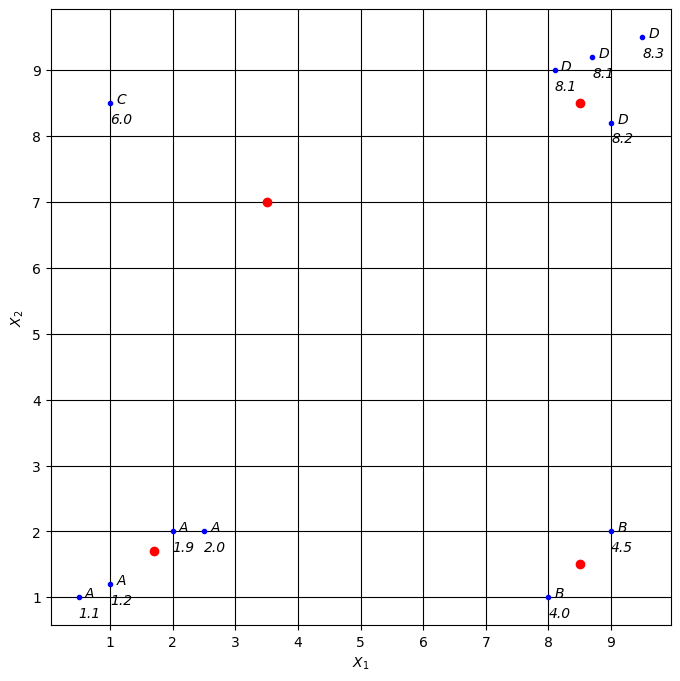

In [ ]:
# визуализация выборки
fig, ax = plt.subplots(figsize=(8,8))

ax.plot(data_train['x1'], data_train['x2'], 'b.', \
         data_test['x1'], data_test['x2'], 'ro')

# деления на осях и сетка
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.grid(which='major', color = 'k')

# подписи к осям
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')

# подписи
for coords in data_train[['x1','x2', 'y', 'y_clas']].values:
    x1, x2, y_cl, cl = coords[0], coords[1], coords[2], coords[3]
    #label = '{} ({})'.format(y_cl, cl)
    #ax.text(x1 + 0.1, x2, label, style='italic', fontsize=7)
    ax.text(x1 + 0.1, x2, cl, style='italic', fontsize=10)
    ax.text(x1, x2-0.3, y_cl, style='italic', fontsize=10)

plt.show()

### Фаза обучения

- Особенность метода заключается в том, что фаза обучения как таковая отсутствует. При обучении необходимо только сохранить обучающую выборку $X^{train}|Y^{train}$, которая будет использоваться для выбора ближайших соседей на этапе предсказания.

- В этом отношении k-NN очень нетипичный метод. В большинстве других методов на этапе обучения используется массивная обработка данных и построение сложной модели аппроксимации для дальнейших предсказаний.

#### Пример с регрессией

In [ ]:
# создаем объект класса
simple_knn_regr = SimpleKNN()

In [ ]:
# вызываем метод обучения
simple_knn_regr.fit(data_train[['x1','x2']], data_train['y'])

In [ ]:
# параметры метода
# матрица объект-признак
simple_knn_regr._X_train

,x1,x2
0,0.5,1.0
1,1.0,1.2
2,2.0,2.0
3,2.5,2.0
4,8.0,1.0
5,9.0,2.0
6,1.0,8.5
7,8.1,9.0
8,9.0,8.2
9,8.7,9.2


In [ ]:
# вектор целевого признака
simple_knn_regr._y_train

0     1.1
1     1.2
2     1.9
3     2.0
4     4.0
5     4.5
6     6.0
7     8.1
8     8.2
9     8.1
10    8.3
Name: y, dtype: float64

#### Пример с классификацией

In [ ]:
simple_knn_clas = SimpleKNN()
simple_knn_clas.fit(data_train[['x1','x2']], data_train['y_clas'])

In [ ]:
simple_knn_clas._X_train

,x1,x2
0,0.5,1.0
1,1.0,1.2
2,2.0,2.0
3,2.5,2.0
4,8.0,1.0
5,9.0,2.0
6,1.0,8.5
7,8.1,9.0
8,9.0,8.2
9,8.7,9.2


In [ ]:
simple_knn_clas._y_train

0     A
1     A
2     A
3     A
4     B
5     B
6     C
7     D
8     D
9     D
10    D
Name: y_clas, dtype: object

### Фаза предсказания

Фаза предсказания в методе ближайших соседей достаточно проста (здесь разобран наиболее простой алгоритм):
1. Необходимо вычислить расстояние от искомой точки до всех точек обучающей выборки:
  1. Для того, чтобы вычислить расстояние, в пространстве точек необходимо ввести метрику (функцию дистанции).
  1. Наиболее часто используется Евклидова метрика. Для векторов $p$ и $q$ в n-мерном пространстве:
  $$d(p,q)= \sqrt{ (p_1-q_1)^2 + (p_2-q_2)^2 + \cdots + (p_n-q_n)^2 } = \sqrt{ \sum_{i=1}^{n} (p_i-q_i)^2} $$
  Также могут использоваться более сложные метрики https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html
  
1. Сортируем массив найденных расстояний по возрастанию.
1. Выбираем K первых элементов массива (соответствующих точкам обучающей выборки, наиболее близких к искомой), знаем $Y_{o}^{train}$ для этих точек, объединяем найденные $Y_{o}^{train}$ в массив $YK^{train}$. Таким образом, массив $YK^{train}$ - это подмножество вектора $Y^{train}$, соответствующий  K точкам обучающей выборки, наиболее близким к искомой точке.
1. Для полученого массива $YK^{train}$ необходимо вычислить регрессию или класификацию:
    - В случае регрессии берется среднее по всем значениям массива - $mean(YK^{train})$
    - В случае классификации возвращается метка класса, наиболее часто встречающегося в $YK^{train}$. То есть мы присоединяем точку к тому классу, к которому уже принадлежит больше всего соседей.
    - Существуют другие подходы к классификации, например возвращать метку класса для наиболее близкого соседа (в этом случае фактически не учитывается гиперпараметр К).


In [ ]:
# первая строка тестовой выборки
data_test_0 = [x for x in data_test[['x1','x2']].iloc[0]]
data_test_0

[1.7, 1.7]


**************************************
Проверяемая точка:  [1.7, 1.7]
**************************************
Вывод отсортированного списка соседей:
X1=2.0, X2=2.0, y=1.9, расстояние=0.42
X1=2.5, X2=2.0, y=2.0, расстояние=0.85
X1=1.0, X2=1.2, y=1.2, расстояние=0.86
X1=0.5, X2=1.0, y=1.1, расстояние=1.39
X1=8.0, X2=1.0, y=4.0, расстояние=6.34
X1=1.0, X2=8.5, y=6.0, расстояние=6.84
X1=9.0, X2=2.0, y=4.5, расстояние=7.31
X1=8.1, X2=9.0, y=8.1, расстояние=9.71
X1=9.0, X2=8.2, y=8.2, расстояние=9.77
X1=8.7, X2=9.2, y=8.1, расстояние=10.26
X1=9.5, X2=9.5, y=8.3, расстояние=11.03

Вывод расстояния для отсортированного списка соседей:


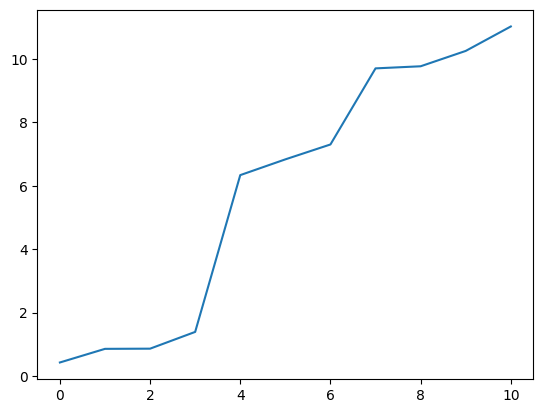

Вывод К ближайших соседей:
X1=2.0, X2=2.0, y=1.9, расстояние=0.42
X1=2.5, X2=2.0, y=2.0, расстояние=0.85
X1=1.0, X2=1.2, y=1.2, расстояние=0.86
X1=0.5, X2=1.0, y=1.1, расстояние=1.39
X1=8.0, X2=1.0, y=4.0, расстояние=6.34

Визуализация К ближайших соседей:


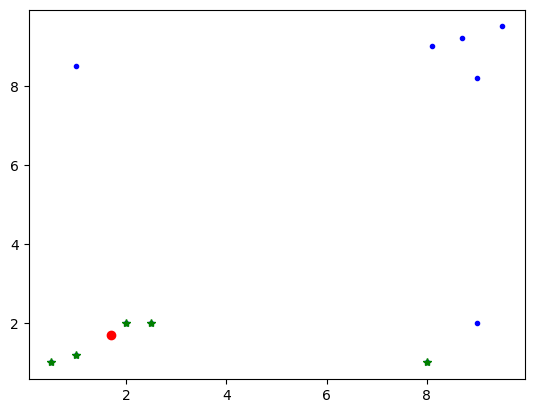

2.04

In [ ]:
# построим предсказание для одного объекта (регрессия)
simple_knn_regr_0 = simple_knn_regr.predict_for_single_object(K=5, \
                          prediction_type=PredictionType.REGRESSION, \
                          X_o=data_test_0)
simple_knn_regr_0

In [ ]:
# Среднее значение y для соседей
np.mean([1.9, 2.0, 1.2, 1.1, 4.0])

2.04


**************************************
Проверяемая точка:  [1.7, 1.7]
**************************************
Вывод отсортированного списка соседей:
X1=2.0, X2=2.0, y=A, расстояние=0.42
X1=2.5, X2=2.0, y=A, расстояние=0.85
X1=1.0, X2=1.2, y=A, расстояние=0.86
X1=0.5, X2=1.0, y=A, расстояние=1.39
X1=8.0, X2=1.0, y=B, расстояние=6.34
X1=1.0, X2=8.5, y=C, расстояние=6.84
X1=9.0, X2=2.0, y=B, расстояние=7.31
X1=8.1, X2=9.0, y=D, расстояние=9.71
X1=9.0, X2=8.2, y=D, расстояние=9.77
X1=8.7, X2=9.2, y=D, расстояние=10.26
X1=9.5, X2=9.5, y=D, расстояние=11.03

Вывод расстояния для отсортированного списка соседей:


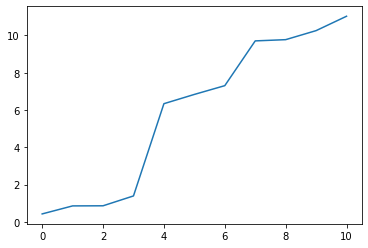

Вывод К ближайших соседей:
X1=2.0, X2=2.0, y=A, расстояние=0.42
X1=2.5, X2=2.0, y=A, расстояние=0.85
X1=1.0, X2=1.2, y=A, расстояние=0.86
X1=0.5, X2=1.0, y=A, расстояние=1.39
X1=8.0, X2=1.0, y=B, расстояние=6.34

Визуализация К ближайших соседей:


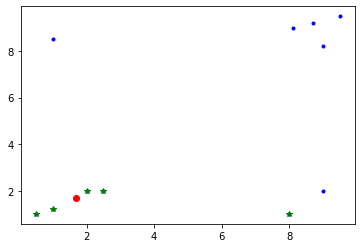

Классы, соответствующие К ближайшим соседям:
класс=A, количество элементов=4
класс=B, количество элементов=1


'A'

In [ ]:
# построим предсказание для одного объекта (классификация)
simple_knn_clas_0 = simple_knn_clas.predict_for_single_object(K=5, \
                          prediction_type=PredictionType.CLASSIFICATION, \
                          X_o=data_test_0)
simple_knn_clas_0


**************************************
Проверяемая точка:  [1.7, 1.7]
**************************************
Вывод отсортированного списка соседей:
X1=2.0, X2=2.0, y=1.9, расстояние=0.42
X1=2.5, X2=2.0, y=2.0, расстояние=0.85
X1=1.0, X2=1.2, y=1.2, расстояние=0.86
X1=0.5, X2=1.0, y=1.1, расстояние=1.39
X1=8.0, X2=1.0, y=4.0, расстояние=6.34
X1=1.0, X2=8.5, y=6.0, расстояние=6.84
X1=9.0, X2=2.0, y=4.5, расстояние=7.31
X1=8.1, X2=9.0, y=8.1, расстояние=9.71
X1=9.0, X2=8.2, y=8.2, расстояние=9.77
X1=8.7, X2=9.2, y=8.1, расстояние=10.26
X1=9.5, X2=9.5, y=8.3, расстояние=11.03

Вывод расстояния для отсортированного списка соседей:


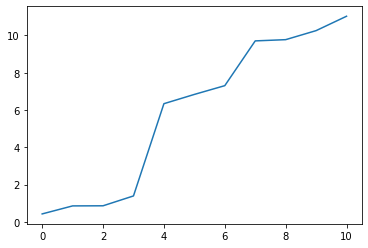

Вывод К ближайших соседей:
X1=2.0, X2=2.0, y=1.9, расстояние=0.42
X1=2.5, X2=2.0, y=2.0, расстояние=0.85
X1=1.0, X2=1.2, y=1.2, расстояние=0.86
X1=0.5, X2=1.0, y=1.1, расстояние=1.39
X1=8.0, X2=1.0, y=4.0, расстояние=6.34

Визуализация К ближайших соседей:


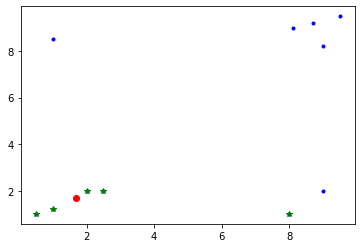


**************************************
Проверяемая точка:  [3.5, 7.0]
**************************************
Вывод отсортированного списка соседей:
X1=1.0, X2=8.5, y=6.0, расстояние=2.92
X1=8.1, X2=9.0, y=8.1, расстояние=5.02
X1=2.5, X2=2.0, y=2.0, расстояние=5.10
X1=2.0, X2=2.0, y=1.9, расстояние=5.22
X1=9.0, X2=8.2, y=8.2, расстояние=5.63
X1=8.7, X2=9.2, y=8.1, расстояние=5.65
X1=1.0, X2=1.2, y=1.2, расстояние=6.32
X1=9.5, X2=9.5, y=8.3, расстояние=6.50
X1=0.5, X2=1.0, y=1.1, расстояние=6.71
X1=9.0, X2=2.0, y=4.5, расстояние=7.43
X1=8.0, X2=1.0, y=4.0, расстояние=7.50

Вывод расстояния для отсортированного списка соседей:


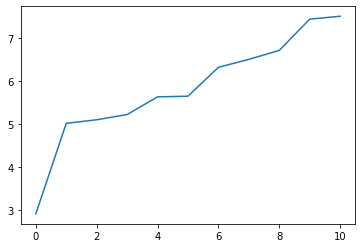

Вывод К ближайших соседей:
X1=1.0, X2=8.5, y=6.0, расстояние=2.92
X1=8.1, X2=9.0, y=8.1, расстояние=5.02
X1=2.5, X2=2.0, y=2.0, расстояние=5.10
X1=2.0, X2=2.0, y=1.9, расстояние=5.22
X1=9.0, X2=8.2, y=8.2, расстояние=5.63

Визуализация К ближайших соседей:


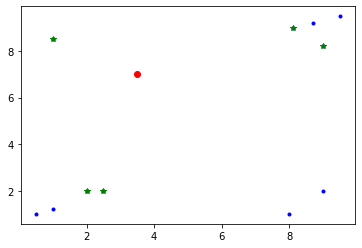


**************************************
Проверяемая точка:  [8.5, 1.5]
**************************************
Вывод отсортированного списка соседей:
X1=8.0, X2=1.0, y=4.0, расстояние=0.71
X1=9.0, X2=2.0, y=4.5, расстояние=0.71
X1=2.5, X2=2.0, y=2.0, расстояние=6.02
X1=2.0, X2=2.0, y=1.9, расстояние=6.52
X1=9.0, X2=8.2, y=8.2, расстояние=6.72
X1=1.0, X2=1.2, y=1.2, расстояние=7.51
X1=8.1, X2=9.0, y=8.1, расстояние=7.51
X1=8.7, X2=9.2, y=8.1, расстояние=7.70
X1=0.5, X2=1.0, y=1.1, расстояние=8.02
X1=9.5, X2=9.5, y=8.3, расстояние=8.06
X1=1.0, X2=8.5, y=6.0, расстояние=10.26

Вывод расстояния для отсортированного списка соседей:


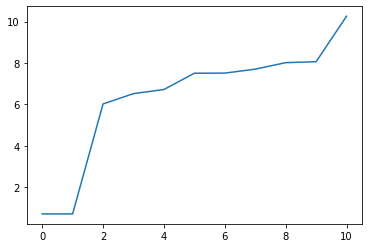

Вывод К ближайших соседей:
X1=8.0, X2=1.0, y=4.0, расстояние=0.71
X1=9.0, X2=2.0, y=4.5, расстояние=0.71
X1=2.5, X2=2.0, y=2.0, расстояние=6.02
X1=2.0, X2=2.0, y=1.9, расстояние=6.52
X1=9.0, X2=8.2, y=8.2, расстояние=6.72

Визуализация К ближайших соседей:


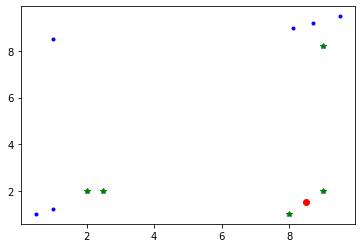


**************************************
Проверяемая точка:  [8.5, 8.5]
**************************************
Вывод отсортированного списка соседей:
X1=9.0, X2=8.2, y=8.2, расстояние=0.58
X1=8.1, X2=9.0, y=8.1, расстояние=0.64
X1=8.7, X2=9.2, y=8.1, расстояние=0.73
X1=9.5, X2=9.5, y=8.3, расстояние=1.41
X1=9.0, X2=2.0, y=4.5, расстояние=6.52
X1=1.0, X2=8.5, y=6.0, расстояние=7.50
X1=8.0, X2=1.0, y=4.0, расстояние=7.52
X1=2.5, X2=2.0, y=2.0, расстояние=8.85
X1=2.0, X2=2.0, y=1.9, расстояние=9.19
X1=1.0, X2=1.2, y=1.2, расстояние=10.47
X1=0.5, X2=1.0, y=1.1, расстояние=10.97

Вывод расстояния для отсортированного списка соседей:


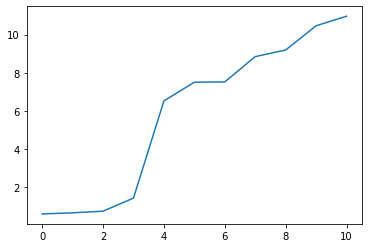

Вывод К ближайших соседей:
X1=9.0, X2=8.2, y=8.2, расстояние=0.58
X1=8.1, X2=9.0, y=8.1, расстояние=0.64
X1=8.7, X2=9.2, y=8.1, расстояние=0.73
X1=9.5, X2=9.5, y=8.3, расстояние=1.41
X1=9.0, X2=2.0, y=4.5, расстояние=6.52

Визуализация К ближайших соседей:


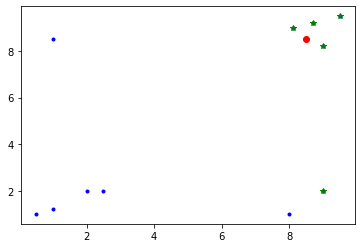

[2.04, 5.24, 4.12, 7.44]

In [ ]:
# Для всех объектов тестовой выборки (регрессия)
simple_knn_regr_prediction = simple_knn_regr.predict(K=5, \
                          prediction_type=PredictionType.REGRESSION, \
                          X_test=data_test[['x1','x2']])
simple_knn_regr_prediction


**************************************
Проверяемая точка:  [1.7, 1.7]
**************************************
Вывод отсортированного списка соседей:
X1=2.0, X2=2.0, y=A, расстояние=0.42
X1=2.5, X2=2.0, y=A, расстояние=0.85
X1=1.0, X2=1.2, y=A, расстояние=0.86
X1=0.5, X2=1.0, y=A, расстояние=1.39
X1=8.0, X2=1.0, y=B, расстояние=6.34
X1=1.0, X2=8.5, y=C, расстояние=6.84
X1=9.0, X2=2.0, y=B, расстояние=7.31
X1=8.1, X2=9.0, y=D, расстояние=9.71
X1=9.0, X2=8.2, y=D, расстояние=9.77
X1=8.7, X2=9.2, y=D, расстояние=10.26
X1=9.5, X2=9.5, y=D, расстояние=11.03

Вывод расстояния для отсортированного списка соседей:


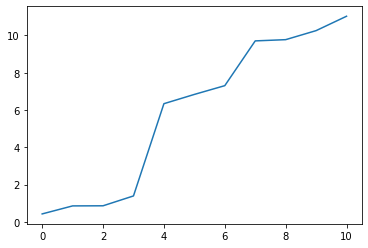

Вывод К ближайших соседей:
X1=2.0, X2=2.0, y=A, расстояние=0.42
X1=2.5, X2=2.0, y=A, расстояние=0.85
X1=1.0, X2=1.2, y=A, расстояние=0.86

Визуализация К ближайших соседей:


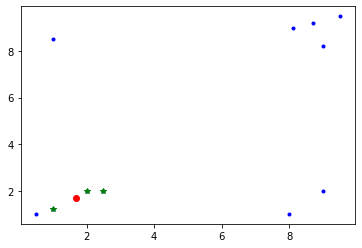

Классы, соответствующие К ближайшим соседям:
класс=A, количество элементов=3

**************************************
Проверяемая точка:  [3.5, 7.0]
**************************************
Вывод отсортированного списка соседей:
X1=1.0, X2=8.5, y=C, расстояние=2.92
X1=8.1, X2=9.0, y=D, расстояние=5.02
X1=2.5, X2=2.0, y=A, расстояние=5.10
X1=2.0, X2=2.0, y=A, расстояние=5.22
X1=9.0, X2=8.2, y=D, расстояние=5.63
X1=8.7, X2=9.2, y=D, расстояние=5.65
X1=1.0, X2=1.2, y=A, расстояние=6.32
X1=9.5, X2=9.5, y=D, расстояние=6.50
X1=0.5, X2=1.0, y=A, расстояние=6.71
X1=9.0, X2=2.0, y=B, расстояние=7.43
X1=8.0, X2=1.0, y=B, расстояние=7.50

Вывод расстояния для отсортированного списка соседей:


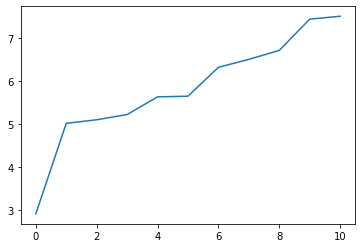

Вывод К ближайших соседей:
X1=1.0, X2=8.5, y=C, расстояние=2.92
X1=8.1, X2=9.0, y=D, расстояние=5.02
X1=2.5, X2=2.0, y=A, расстояние=5.10

Визуализация К ближайших соседей:


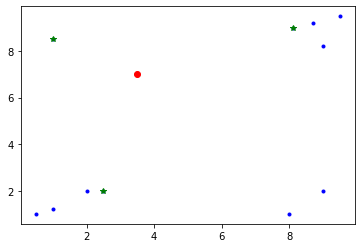

Классы, соответствующие К ближайшим соседям:
класс=A, количество элементов=1
класс=C, количество элементов=1
класс=D, количество элементов=1

**************************************
Проверяемая точка:  [8.5, 1.5]
**************************************
Вывод отсортированного списка соседей:
X1=8.0, X2=1.0, y=B, расстояние=0.71
X1=9.0, X2=2.0, y=B, расстояние=0.71
X1=2.5, X2=2.0, y=A, расстояние=6.02
X1=2.0, X2=2.0, y=A, расстояние=6.52
X1=9.0, X2=8.2, y=D, расстояние=6.72
X1=1.0, X2=1.2, y=A, расстояние=7.51
X1=8.1, X2=9.0, y=D, расстояние=7.51
X1=8.7, X2=9.2, y=D, расстояние=7.70
X1=0.5, X2=1.0, y=A, расстояние=8.02
X1=9.5, X2=9.5, y=D, расстояние=8.06
X1=1.0, X2=8.5, y=C, расстояние=10.26

Вывод расстояния для отсортированного списка соседей:


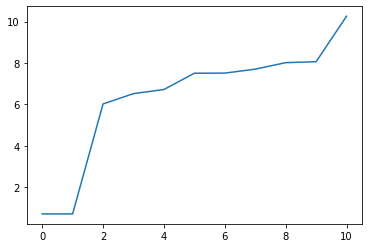

Вывод К ближайших соседей:
X1=8.0, X2=1.0, y=B, расстояние=0.71
X1=9.0, X2=2.0, y=B, расстояние=0.71
X1=2.5, X2=2.0, y=A, расстояние=6.02

Визуализация К ближайших соседей:


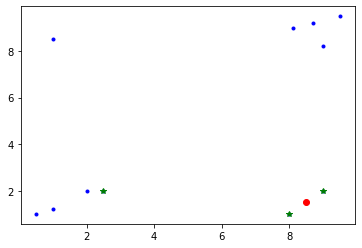

Классы, соответствующие К ближайшим соседям:
класс=B, количество элементов=2
класс=A, количество элементов=1

**************************************
Проверяемая точка:  [8.5, 8.5]
**************************************
Вывод отсортированного списка соседей:
X1=9.0, X2=8.2, y=D, расстояние=0.58
X1=8.1, X2=9.0, y=D, расстояние=0.64
X1=8.7, X2=9.2, y=D, расстояние=0.73
X1=9.5, X2=9.5, y=D, расстояние=1.41
X1=9.0, X2=2.0, y=B, расстояние=6.52
X1=1.0, X2=8.5, y=C, расстояние=7.50
X1=8.0, X2=1.0, y=B, расстояние=7.52
X1=2.5, X2=2.0, y=A, расстояние=8.85
X1=2.0, X2=2.0, y=A, расстояние=9.19
X1=1.0, X2=1.2, y=A, расстояние=10.47
X1=0.5, X2=1.0, y=A, расстояние=10.97

Вывод расстояния для отсортированного списка соседей:


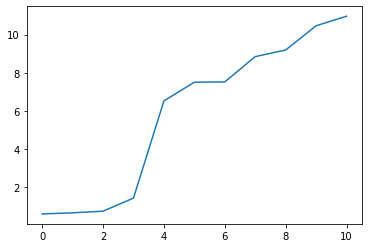

Вывод К ближайших соседей:
X1=9.0, X2=8.2, y=D, расстояние=0.58
X1=8.1, X2=9.0, y=D, расстояние=0.64
X1=8.7, X2=9.2, y=D, расстояние=0.73

Визуализация К ближайших соседей:


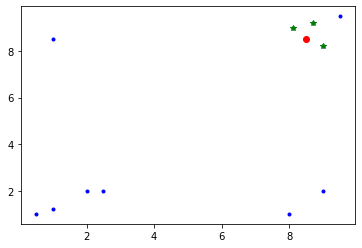

Классы, соответствующие К ближайшим соседям:
класс=D, количество элементов=3


['A', 'A', 'B', 'D']

In [ ]:
# Для всех объектов тестовой выборки (классификация)
simple_knn_clas_prediction = simple_knn_clas.predict(K=3, \
                          prediction_type=PredictionType.CLASSIFICATION, \
                          X_test=data_test[['x1','x2']])
simple_knn_clas_prediction

## [Использование классов scikit-learn](https://scikit-learn.org/stable/modules/neighbors.html)

- [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) - для решения задачи регрессии
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) - для решения задачи классификации

Также существуют разновидности алгоритма, рассматривающие ближайших соседей в рамках некоторой окрестности (радиуса):
- [RadiusNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html)
- [RadiusNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

### Классификация

In [ ]:
KNeighborsClassifierObj = KNeighborsClassifier(n_neighbors=3)
KNeighborsClassifierObj

KNeighborsClassifier(n_neighbors=3)

In [ ]:
KNeighborsClassifierObj.fit(data_train[['x1','x2']], data_train['y_clas'])
KNeighborsClassifierObj.predict(data_test[['x1','x2']])

array(['A', 'A', 'B', 'D'], dtype=object)

In [ ]:
simple_knn_clas = SimpleKNN()
simple_knn_clas.fit(data_train[['x1','x2']], data_train['y_clas'])
simple_knn_clas_prediction = simple_knn_clas.predict(K=3, \
                          prediction_type=PredictionType.CLASSIFICATION, \
                          X_test=data_test[['x1','x2']], verbose = False)
np.array(simple_knn_clas_prediction)

array(['A', 'A', 'B', 'D'], dtype='<U1')

### Регрессия

In [ ]:
KNeighborsRegressorObj = KNeighborsRegressor()
KNeighborsRegressorObj

KNeighborsRegressor()

In [ ]:
KNeighborsRegressorObj.fit(data_train[['x1','x2']], data_train['y'])
KNeighborsRegressorObj.predict(data_test[['x1','x2']])

array([2.04, 5.24, 4.12, 7.44])

In [ ]:
simple_knn_regr = SimpleKNN()
simple_knn_regr.fit(data_train[['x1','x2']], data_train['y'])
simple_knn_regr_prediction = simple_knn_regr.predict(K=5, \
                          prediction_type=PredictionType.REGRESSION, \
                          X_test=data_test[['x1','x2']], verbose = False)
np.array(simple_knn_regr_prediction)

array([2.04, 5.24, 4.12, 7.44])

## Достоинства и недостатки

### Достоинства
- Простота и универсальность метода.
- Возможность использования для классификации и регрессии.
- Возможность использования для обучения без учителя.

### Недостатки
- Метод в целом считается не очень точным.
- Зависимость от гиперпараметра K.
- При большом количестве точек перебор и вычисление расстояния занимают много времени. Для этого используются различные методы ускорения алгоритма - https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbor-algorithms, в частности [KDTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) и [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html).
- Статья, посвященная алгоритму [BallTree.](http://people.ee.duke.edu/~lcarin/liu06a.pdf)

## Особенности алгоритма

### Обучение без учителя
Поскольку метод фактически не строит модель $M$ и для поиска ближайших соседей использует только меру близости между $X^{train}$ и $X^{test}$, то в некоторых случаях $Y^{train}$ игнорируют, и метод k-NN рассматривают как один из методов обучения без учителя. В этом случае k-NN можно рассматривать как специфическую разновидность алгоритма кластеризации - http://scikit-learn.org/stable/modules/neighbors.html

### Масштабирование признаков
Если признаки лежат в различных диапазонах, то необходимо их масштабировать с использованием MinMax масштабирования или масштабирования на основе Z-оценки.